In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

import pathlib
import os, sys


In [7]:
# data download


# path_2_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_2_file = pathlib.Path(path_2_zip).parent/'spa-eng/spa.txt'

# print(path_2_file)
# print(path_2_zip)

2638744/2638744 [==============================] - 0s 0us/step
C:\Users\Vincent\.keras\datasets\spa-eng\spa.txt
C:\Users\Vincent\.keras\datasets\spa-eng.zip


In [2]:
#data path
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = pathlib.Path(os.path.join(fileDir, r"dataset\spa.txt"))

print(filename)

F:\program repo\NLP-translation\dataset\spa.txt


In [3]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])

    return target, context



In [4]:
target_raw, context_raw = load_data(filename)

In [5]:
#check data
print(target_raw[0])
print(context_raw[0])

Go.
Ve.


In [6]:
#meta data

max_vocab_size = 5000

buffer_size = len(context_raw)
batch_size = 64

train_set_proportion = 0.8

is_train = np.random.uniform(size=(len(target_raw), )) < train_set_proportion



In [7]:
#set up tf dataset
train_set_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(buffer_size)
    .batch(batch_size)
)

val_set_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(buffer_size)
    .batch(batch_size)
)

In [8]:
#data check

for context_strings, target_strings in train_set_raw.take(1):
    print(context_strings[:6])
    print()
    print(target_strings[:6])
    break

tf.Tensor(
[b'Es mi t\xc3\xado.' b'\xc2\xbfCu\xc3\xa1l es la prisa?'
 b'Mi hijo es mi mayor dolor de cabeza.' b'Espero mucho de \xc3\xa9l.'
 b'Hay un televisor en este cuarto.' b'Es mi mejor amigo.'], shape=(6,), dtype=string)

tf.Tensor(
[b'He is my uncle.' b"What's the hurry?" b'My son is my biggest headache.'
 b'I expect much of him.' b'There is a television in this room.'
 b"He's my best friend."], shape=(6,), dtype=string)


In [9]:
def tf_lower_and_split_punct(text):
    #split accented characters
    text = tf_text.normalize_utf8(text, 'NFKD') #NFKD is one of the normalization format defined in unicode convention
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


In [10]:
#check

example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

print(example_text.numpy().decode())

print(tf_lower_and_split_punct(example_text).numpy().decode())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'
¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [11]:
#Text vectoriazation

context_text_preprocessor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)

In [12]:
context_text_preprocessor.adapt(train_set_raw.map(lambda context, target: context))

In [13]:
#output check
context_text_preprocessor.get_vocabulary()[:15]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'que',
 'de',
 'el',
 'a',
 'no',
 'tom',
 'la',
 '?',
 '¿',
 'en']

In [14]:
target_text_preprocessor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)



In [15]:
target_text_preprocessor.adapt(train_set_raw.map(lambda context, target: target))

In [16]:
#output check
target_text_preprocessor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [17]:
example_tokens = context_text_preprocessor(context_strings)
print(example_tokens[ : 3])

<tf.RaggedTensor [[2, 15, 24, 591, 4, 3], [2, 13, 155, 15, 11, 945, 12, 3],
 [2, 24, 305, 15, 24, 330, 497, 6, 404, 4, 3]]>


In [18]:
#convert token value back to words

context_vocab = np.array(context_text_preprocessor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
print(' '.join(tokens))


target_vocab = np.array(target_text_preprocessor.get_vocabulary())
tk2 = target_vocab[target_text_preprocessor(target_strings)[0].numpy()]
print(' '.join(tk2))

[START] es mi tio . [END]
[START] he is my uncle . [END]


Text(0.5, 1.0, 'Mask')

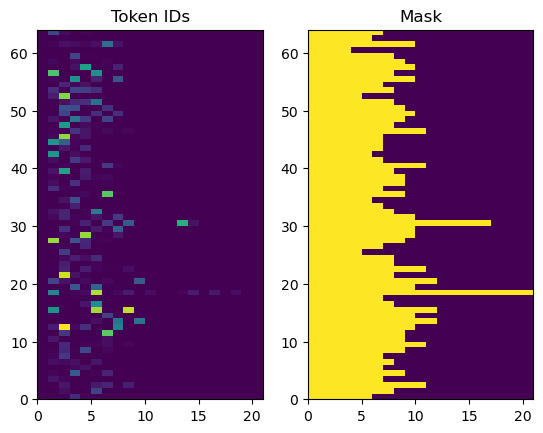

In [19]:
# visualization

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [20]:
def process_text(context, target):
    context = context_text_preprocessor(context).to_tensor()
    target = target_text_preprocessor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

train_ds = train_set_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_set_raw.map(process_text, tf.data.AUTOTUNE)

In [23]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(5):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2   53    1 3583  834    4    3    0    0    0]

[  2 116  35 281   7  46  34  68  17   1]
[116  35 281   7  46  34  68  17   1  63]
[   2  198  698   17    1   14   11 3429    4    3]

[   2  122  757   57 2505   14    5 2495    4    0]
[ 122  757   57 2505   14    5 2495    4    3    0]
[   2   13   18   94   21   16 1669 3380   12    3]

[   2   20    8  108   23   25   10 1842 3130   11]
[  20    8  108   23   25   10 1842 3130   11    3]
[   2   15   42 2627    4    3    0    0    0    0]

[   2   50   58 1559    4    0    0    0    0    0]
[  50   58 1559    4    3    0    0    0    0    0]
[  2  13  76  20  11 394   6  10  12   3]

[  2 683 151 424  11   0   0   0   0   0]
[683 151 424  11   3   0   0   0   0   0]


# ENCODER

In [24]:
units = 256